In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install transformers

In [ ]:
import pandas as pd
import numpy as np
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4
import time
import datetime
import random
import itertools

## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import (
    Dataset, 
    DataLoader,
    TensorDataset, 
    random_split, 
    RandomSampler, 
    SequentialSampler)

# Transformers
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    AdamW,
    get_linear_schedule_with_warmup)

In [ ]:
def encode_dataframe(statement_col, target_col, unpack=False):
    # Tokenize statements
    bert_encoded_dict = statement_col.apply(lambda sent: bert_tokenizer.encode_plus(
                                      sent,                      # Sentence to encode.
                                      add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                      max_length = 120,           # Pad & truncate all sentences.
                                      pad_to_max_length = True,
                                      return_attention_mask = True,   # Construct attn. masks.
                                      return_tensors = 'pt',     # Return pytorch tensors.
                                      truncation = True
                                ))
    bert_input_ids = torch.cat([item['input_ids'] for item in bert_encoded_dict], dim=0)
    bert_attention_masks = torch.cat([item['attention_mask'] for item in bert_encoded_dict], dim=0)

    # Format targets
    labels = torch.tensor(target_col)
    sentence_ids = torch.tensor(range(len(target_col)))

    # Combine the training inputs into a TensorDataset
    bert_dataset = TensorDataset(sentence_ids, bert_input_ids, bert_attention_masks, labels)

    # Remove indices
    trial_dataset =  index_remover(bert_dataset)

    if unpack:
        return bert_input_ids, bert_attention_masks, labels
    else:
        return trial_dataset

def index_remover(tensordata):
    input_ids = []
    attention_masks = []
    labels = []
   
    for a,b,c,d in tensordata:
        input_ids.append(b.tolist())
        attention_masks.append(c.tolist())
        labels.append(d.tolist())
        
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)
    
    final_dataset =  TensorDataset(input_ids, attention_masks, labels)
    return final_dataset

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# Device
device = torch.device("cuda:0")

# BERT
bert_model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/fake-news-explainability/bert_model").to(device)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
# Target labels
label_encodings6 = {
    'pants-fire': 0, 
    'false':      1, 
    'barely-true':2, 
    'half-true':  3, 
    'mostly-true':4,
    'true':       5
}

## Test on Negated Inputs

In [ ]:
# Read data
df_positive = pd.read_csv("/content/drive/MyDrive/fake-news-explainability/liar_positive.csv")#.iloc[:500]
df_negative = pd.read_csv("/content/drive/MyDrive/fake-news-explainability/liar_negative.csv")#.iloc[:500]

# Relabel target
df_positive['target'] = df_positive['label'].apply(lambda x: label_encodings6[x])
df_negative['target'] = df_negative['label'].apply(lambda x: label_encodings6[x])

# Balance data
class_ids = df_positive.reset_index().groupby('target').agg({'index':list})
chosen_ids = [random.sample(class_ids.loc[i,'index'], 300) for i in range(class_ids.shape[0])]
chosen_ids = list(itertools.chain.from_iterable(chosen_ids))
df_positive = df_positive.iloc[chosen_ids].reset_index(drop=True)
df_negative = df_negative.iloc[chosen_ids].reset_index(drop=True)

# Reformat test and validation dataframes
input_pos, attention_pos, labels_pos = encode_dataframe(df_positive['statement'], df_positive['target'], unpack=True)
input_neg, attention_neg, labels_neg = encode_dataframe(df_negative['statement'], df_negative['target'], unpack=True)

In [ ]:
# Run the inputs through the model
with torch.no_grad():
    outputs_pos = bert_model(input_pos.to(device),
                             token_type_ids=None, 
                             attention_mask=attention_pos.to(device),
                             labels=labels_pos.to(device))
    outputs_neg = bert_model(input_neg.to(device),
                             token_type_ids=None,
                             attention_mask=attention_neg.to(device),
                             labels=labels_neg.to(device))
    
# Original LIAR accuracy
print(f"Original LIAR Acc: {flat_accuracy(outputs_pos[1].detach().cpu().numpy(), labels_pos.to('cpu').numpy())}")

# Negated LIAR accuracy
print(f"Negated LIAR Acc: {flat_accuracy(outputs_neg[1].detach().cpu().numpy(), labels_neg.to('cpu').numpy())}")

Original LIAR Acc: 0.4461111111111111
Negated LIAR Acc: 0.38666666666666666


(array([ 19.,  87., 132., 149., 145., 115., 110., 103.,  95.,  93.,  80.,
         86.,  61.,  69.,  54.,  45.,  36.,  40.,  41.,  26.,  24.,  18.,
         18.,  25.,  17.,  12.,  12.,  13.,  15.,   9.,   9.,   7.,   4.,
          3.,   2.,   5.,   3.,   3.,   1.,   2.,   2.,   0.,   0.,   0.,
          1.,   4.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.03740244, 0.07480487, 0.11220731, 0.14960974,
        0.18701218, 0.22441462, 0.26181704, 0.2992195 , 0.3366219 ,
        0.37402436, 0.41142678, 0.44882923, 0.48623165, 0.5236341 ,
        0.5610365 , 0.598439  , 0.63584137, 0.6732438 , 0.7106463 ,
        0.7480487 , 0.7854511 , 0.82285357, 0.860256  , 0.89765847,
        0.93506086, 0.9724633 , 1.0098658 , 1.0472682 , 1.0846707 ,
        1.122073  , 1.1594754 , 1.196878  , 1.2342803 , 1.2716827 ,
        1.3090852 , 1.3464876 , 1.3838902 , 1.4212925 , 1.4586949 ,
        1.4960974 , 1.5334998 , 1.5709022 , 1.

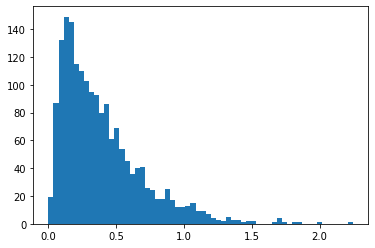

In [ ]:
# Difference between predictions
import matplotlib.pyplot as plt
mse = torch.norm(outputs_pos[1]-outputs_neg[1], 2, dim=1)
plt.hist(mse.cpu(), bins=60)

In [ ]:
for i in torch.where(mse>1.5)[0].cpu():
    print(df_positive['statement'][int(i)])
    print(df_negative['statement'][int(i)])
    print('\n')

McCain's energy plan is a "single-answer proposition" new domestic oil drilling.
McCain's energy plan is not a "single-answer proposition" new domestic oil drilling.


New food safety legislation will regulate backyard gardening.
New food safety legislation will not regulate backyard gardening.


Scott Walkers income tax plan is a tax hike. It increases taxes for nearly 80% of the people in the state.
Scott Walkers income tax plan is not a tax hike. It increases taxes for nearly 80% of the people in the state.


A United Nations working group has adopted a proposed agenda to enable member nations to disarm civilians within their borders.
A United Nations working group has not adopted a proposed agenda to enable member nations to disarm civilians within their borders.


Congressman Robert Hurt has a plan to cut education by 40 percent.
Congressman Robert Hurt has not a plan to cut education by 40 percent.


The Obama-Clinton war on coal has cost Michigan over 50,000 jobs.
The Obama-Clin

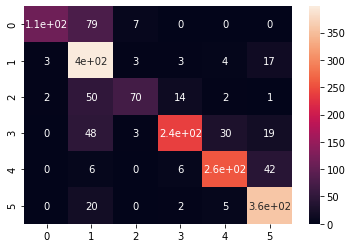

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(torch.argmax(outputs_pos[1].cpu(), axis=1), 
                             torch.argmax(outputs_neg[1].cpu(), axis=1))
sns.heatmap(cf_matrix, annot=True)

## Test on Fake-News Kaggle Dataset

In [ ]:
# Read data
df_train = pd.read_csv("/content/drive/MyDrive/fake-news-explainability/fake_news_train.csv")#.iloc[:500]
df_train = df_train.dropna(subset=['text']).reset_index(drop=True)

# Relabel target
df_train['target'] = df_train['label'].apply(lambda x: 0 if x==0 else 5)

# Reformat test and validation dataframes
df_train_encode = encode_dataframe(df_train['text'], df_train['target'])

# Load data into dataloader
batch_size = 32
bert_train_dataloader = DataLoader(
            df_train_encode,  # The training samples.
            batch_size = batch_size # Trains with this batch size.
        )

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
results = []
# Run the inputs through the model
for batch in bert_train_dataloader:
    with torch.no_grad():
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            outputs = bert_model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        results.append(torch.Tensor(outputs[1].cpu()))

results = torch.vstack(results)

In [ ]:
cutoff = 4

In [ ]:
# Accuracy
results_class = [1 if i>=cutoff else 0 for i in torch.argmax(results, axis=1)]
sum(torch.Tensor(df_train['label'])==torch.Tensor(results_class)) / len(results_class)

tensor(0.4525)